In [ ]:
plt.plot(range(len(plotX)),plotX) 
plt.show()

In [1]:
import numpy as np
import cv2 as cv2
from mss import mss
from PIL import Image, ImageEnhance
import keyboard
# import pyautogui
import time
import tqdm as tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf                                                               
import random
from tqdm import tqdm
from tensorflow.keras.models import model_from_json

In [2]:
class Agent:
    def __init__(self):

        self.model = Sequential([
            Conv2D(32, (8,8), input_shape=(76, 384, 4),
                   strides=(2,2), activation='relu'),
            MaxPooling2D(pool_size=(5,5), strides=(2, 2)),
            Conv2D(64, (4,4), activation='relu', strides=(1,1)),
            MaxPooling2D(pool_size=(7, 7), strides=(3, 3)),
            Conv2D(128, (1, 1), strides=(1,1), activation='relu'),
            MaxPooling2D(pool_size=(3,3), strides=(3,3)),
            Flatten(),
            Dense(384, activation='relu'),
            Dense(64, activation="relu", name="layer1"),
            Dense(8, activation="relu", name="layer2"),
            Dense(3, activation="linear", name="layer3"), #2 outputs
        ])
        self.model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0003))
        self.model.load_weights("DinoGameSpeed.h5")
        self.memory = []
        # print(self.model.summary())
        self.xTrain = []
        self.yTrain = []
        self.loss = []


    def predict(self, state):
        stateConv = state
        # stateConv = np.squeeze(state).reshape(1,-1)
        qval = self.model.predict(np.reshape(stateConv, (1, 76, 384, 4)))
        return qval

    def act(self, state):
        qval = self.predict(state)
        prob = tf.nn.softmax(tf.math.divide((qval.flatten()), 1)) #0.7 is the temperature/exploration factor
        # print(np.array(prob))
        z = np.random.random()
        if z > 0.05:
            # print(np.argmax(qval.flatten()))
            return np.argmax(qval.flatten())
        else:
            return np.random.choice(range(3))
        # action = np.random.choice(range(3), p=np.array(prob))
        return action

    def remember(self, state, nextState, action, reward, done):
        self.memory.append(np.array([state, nextState, action, reward, done]))

    def learn(self):
        self.batchSize = 256

        if len(self.memory) > 100000:
            self.memory = []
            print("trimming memory")
        if len(self.memory) < self.batchSize:
            print("too little info")
            return  # still need to learn, too little memory
        batch = random.sample(self.memory, self.batchSize)
        #check how much time random samples take too

        self.learnBatch(batch)

    def learnBatch(self, batch, alpha=0.9):
        batch = np.array(batch)
        actions = batch[:, 2].reshape(self.batchSize).tolist()
        rewards = batch[:, 3].reshape(self.batchSize).tolist()

        stateToPredict = batch[:, 0].reshape(self.batchSize).tolist()
        nextStateToPredict = batch[:, 1].reshape(self.batchSize).tolist()

        statePrediction = self.model.predict(np.reshape(
            stateToPredict, (self.batchSize, 76, 384, 4)))
        nextStatePrediction = self.model.predict(np.reshape(
            nextStateToPredict, (self.batchSize, 76, 384, 4)))
        statePrediction = np.array(statePrediction)
        nextStatePrediction = np.array(nextStatePrediction)

        for i in range(self.batchSize):
            action = actions[i]
            reward = rewards[i]
            nextState = nextStatePrediction[i]
            qval = statePrediction[i, action]
            if reward < -5: 
                statePrediction[i, action] = reward
            else:
                statePrediction[i, action] += alpha * (reward + 0.95 * np.max(nextState) - qval)
            # # doubleq^

        self.xTrain.append(np.reshape(
            stateToPredict, (self.batchSize, 76, 384, 4)))
        self.yTrain.append(statePrediction)
        history = self.model.fit(
            self.xTrain, self.yTrain, batch_size=5, epochs=1, verbose=0)
        loss = history.history.get("loss")[0]
        print("LOSS: ", loss)
        self.loss.append(loss)
        self.xTrain = []
        self.yTrain = []

In [3]:

class Enviornment:
    def __init__(self):
        self.mon = {'top': 243, 'left': 0, 'width': 1366, 'height': 270}
        # self.mon = {'top': 380, 'left': 0, 'width': 1920, 'height': 380}
        # self.mon = {'top': 1000, 'left': 0, 'width': 3840, 'height': 760}
        self.sct = mss()
        self.counter = 0
        self.startTime = -1
        self.imageBank = []
        self.imageBankLength = 4 #number of frames for the conv net
        self.actionMemory = 2 #init as 2 to show no action taken   
        #image processing
        self.ones = np.ones((76,384,4))
        self.zeros = np.zeros((76,384,4))  
        self.zeros1 = np.zeros((76,384,4))
        self.zeros2 = np.zeros((76,384,4))
        self.zeros3 = np.zeros((76,384,4))
        self.zeros4 = np.zeros((76,384,4))
        self.zeros1[:,:,0] = 1
        self.zeros2[:,:,1] = 1
        self.zeros3[:,:,2] = 1
        self.zeros4[:,:,3] = 1

    def startGame(self):
        #start the game, giving the user a few seconds to click on the chrome tab after starting the code
        for i in reversed(range(3)):
            print("game starting in ", i)
            time.sleep(1)

    def step(self, action):        
        actions ={
            0: 'space',
            1: 'down'
        }            
        if action != self.actionMemory:
            if self.actionMemory != 2:
                keyboard.release(actions.get(self.actionMemory))
            if action != 2:
                keyboard.press(actions.get(action))
        self.actionMemory = action

        screenshot = self.sct.grab(self.mon)
        img = np.array(screenshot)[:, :, 0]
        processedImg = self._processImg(img)
        state = self._imageBankHandler(processedImg)
        done = self._done(processedImg)
        reward = self._getReward(done)
        return state, reward, done

    def reset(self):
        self.startTime = time.time()
        keyboard.press("space")
        time.sleep(0.5)
        keyboard.release("space")
        return self.step(0)

    def _processImg(self, img):
        img = Image.fromarray(img)
        img = img.resize((384, 76), Image.ANTIALIAS)
        # img = ImageEnhance.Contrast(img).enhance(5)
        img = self._contrast(img)
        img = np.reshape(img, (76,384))
        return img

    def _contrast(self,pixvals):
        minval = 32 #np.percentile(pixvals, 2)
        maxval = 171 #np.percentile(pixvals, 98)
        pixvals = np.clip(pixvals, minval, maxval)
        pixvals = ((pixvals - minval) / (maxval - minval))
        # Image.fromarray(pixvals.astype(np.uint8))
        return pixvals

    def _imageBankHandler(self, img):
        # timeTest = time.time()
        img = np.array(img)
        # cv2.imshow("image", img)
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     cv2.destroyAllWindows()
        while len(self.imageBank) < (self.imageBankLength): 
            self.imageBank.append(np.reshape(img,(76,384,1)) * self.ones)

        
        bank = np.array(self.imageBank)
        toReturn = self.zeros
        img1 = (np.reshape(img,(76,384,1)) * self.ones)  * self.zeros1
        img2 = bank[0] * self.zeros2
        img3 = bank[1] * self.zeros3
        img4 = bank[2] * self.zeros4


        toReturn = np.array(img1 + img2 + img3 + img4)
        # toReturn = np.reshape(toReturn, (76,384,4))
        

        self.imageBank.pop(0)
        self.imageBank.append(np.reshape(img,(76 ,384,1)) * self.ones)

        # cv2.imshow("image", np.reshape(toReturn[:,:,0], (76,384,1)))
        # if cv2.waitKey(25) & 0xFF == ord('q'): 
        #     cv2.destroyAllWindows()

        # print("bank Time for loop: ", time.time()-timeTest)

        return toReturn

    def _getReward(self,done):
        if done:
            return -15
        else: 
            return 1
            return time.time() - self.startTime
        
    def _done(self,img):
        img = np.array(img)
        img  = img[30:50, 180:203]
        # cv2.imshow("image",img)
        # if cv2.waitKey(25) & 0xFF == ord('q'): 
        #     cv2.destroyAllWindows()

        val = np.sum(img)
        expectedVal = 331.9352517985612
        # print("val: ", val)
        # print("Difference: ", np.absolute(val-expectedVal))
        if np.absolute(val-expectedVal) > 15: #seems to work well
            return False
        return True

In [4]:
plotX = []
while True:
# if __name__ == "__main__":
    agent = Agent() #currently agent is configured with only 2 actions
    env = Enviornment()
    env.startGame()    
    for i in tqdm(range(4000)):
        state, reward, done = env.reset()
        epReward = 0
        done = False
        episodeTime = time.time()
        stepCounter = 0
        while not done:
            startTime = time.time()
            action = agent.act(state)
            nextState, reward, done = env.step(action)
            agent.remember(state, nextState, action, reward, done)
            if done == True:
                print("breaking")
                break
            state = nextState
            stepCounter += 1
            epReward += reward
            # print("episode time: ", time.time()-startTime)
            # print('\n')
            normalizeFrameRate = 0.05555 #17.5fps
            # while (time.time() - startTime) < normalizeFrameRate:
            #     time.sleep(0.0005)

        #post episode
        if stepCounter != 0:
            print("Avg Frame-Rate: ", 1/((time.time()-episodeTime)/stepCounter))
        plotX.append(epReward)
        print(epReward)
        agent.learn()


       
        if i % 20 == 0:
            agent .model.save_weights ("DinoGameSpeed.h5")
            print( "Saved model to disk")                    
# 
            # print("Time action prediction : ", time.time()-start_time2)
            # start_time2 = time.time()

4000 [20:47<10:54:02, 10.20s/it]LOSS:  3.0347752571105957
breaking
Avg Frame-Rate:  18.430984153550607
123
  4%|▍         | 155/4000 [20:55<10:21:04,  9.69s/it]LOSS:  1.244368076324463
breaking
Avg Frame-Rate:  18.341299450261285
462
  4%|▍         | 156/4000 [21:23<16:11:54, 15.17s/it]LOSS:  1.1914013624191284
breaking
Avg Frame-Rate:  18.31100446761826
106
  4%|▍         | 157/4000 [21:32<13:58:52, 13.10s/it]LOSS:  1.0610860586166382
breaking
Avg Frame-Rate:  19.33822431759397
90
  4%|▍         | 158/4000 [21:38<11:51:57, 11.12s/it]LOSS:  1.0176761150360107
breaking
Avg Frame-Rate:  18.46490004355244
85
  4%|▍         | 159/4000 [21:45<10:21:35,  9.71s/it]LOSS:  0.6177190542221069
breaking
Avg Frame-Rate:  18.463251122547994
181
  4%|▍         | 160/4000 [21:56<10:58:26, 10.29s/it]LOSS:  0.9895769953727722
breaking
Avg Frame-Rate:  18.223267275575612
102
  4%|▍         | 161/4000 [22:04<10:04:23,  9.45s/it]LOSS:  0.5762909650802612
Saved model to disk
breaking
Avg Frame-Rate:  19.210

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[32,76,384,4] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[32,76,384,4] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[IteratorGetNext/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_28634]

Function call stack:
predict_function -> predict_function


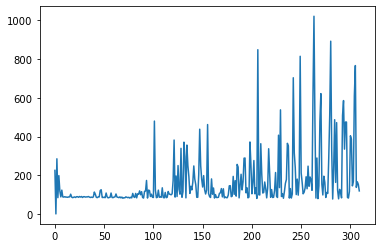

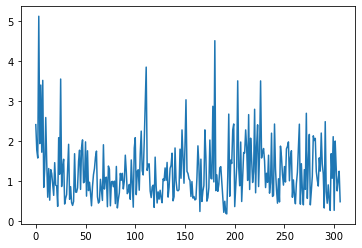

In [5]:
plt.plot(range(len(plotX)),plotX) 
plt.show()
plt.plot(range(len(agent.loss)), agent.loss) 
plt.show() 